In [ ]:
# Dalbyover 59.459  

## Introduction
This report with Python/pandas script is based on data from the drilling at Dalbyobver in Jutland, Denmark and iPython notebook. The report is a tutorial of how various data is imported into a dataframe for further imaging and processing. The data is tested and filters are constructed. 

Wireline logs originates from a number of measurements and it appears clear that they are not entirely adjusted in depth. Gamma data is used to depth match the datasets based on the most relyable dataset. I introduce a method of cross-correlance of the whole dataset, but also how the data can be divided in _depth slices_. 

Kristian Sloth had more information of the the data acquisition: 

<blockquote>In [the] data set I have performed depth correction based on the strong gamma peaks in the lower part of the well, and using TCDS3719-Dalbyover1 as the reference because we know for certain that this well log was recorded from ground level. I had to adjust TRGS8068-Dalbyover4 up by 69 cm and TRGS8068-Dalbyover5 up by 7 cm. After depth correction I merged the two files at 113,68 m depth where their gamma values coincided.</blockquote>

Some convertions are discussed and applied on the data.Resistivity data is temperature-corrected and permeability is converted to Klinkenberg. 

Finally the data is compared and formation factor is calculated and discussed briefly. 

The interest in the dataset from my point of wiew, started with an aim of createing a better velocity model to use for NMO of reflection seismic data, and possible correlation of S and P-wave seismics. However, the upper 40m, the most interesting depths for us, is unfortunately missing. The well needed a steel casting to not collaps and sonic logs are not correct. 

## Import Python modules and packages

A number of modules are used in this small project. Pandas is a data analyst package the resemblance R. Data is stored in dataframes, an array with named columns and rows. Numpy is a fast matrix format, matplotlib is used for plotting. A few scipy functions are aslo used for curve-fitting. 
_%matplotlib inline_ forces Jupyter to generate plots inline fith markup texts and code. A few matplotlib parameters are set, _plt.style.use('ggplot')_ sets a nice style to the plots and a standard size is also specified. 

In [68]:
#Plot in document
%matplotlib inline
#%matplotlib

import numpy as np
import pandas as pd
import numpy.lib.recfunctions
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import gridspec
import matplotlib.mlab as mlab
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy import stats
import math

plt.style.use('ggplot')
#plt.switch_backend('nbagg')
plt.rcParams['figure.figsize']=12,8

print 'Imported!'

Imported!


## Import data from textfiles

This code block reads in the datasets, wireline logs and plug samples. Create a pandas dataframe. 

Some descitions are also made already in the generation of the dataframe. Ex are negative values are excluded from the import by setting the min_value global parameter. Various na values from the indata are defined in the read_LAS() function. csv file is imported with plugdata, but columns are renamed. 

The global variable casing is set to define the section of the well that is cased due to callapsing soft chalk. However, most operations are also performed on this section, it's clearly marked out in the plots, defined in well_plot() function, defined later. 

All units are converted to SI. This might not be the standard for thise kind of data, but helps to avoind conversion problems later. 

In the end of the block some suggested print line give some information of the data. Uncomment the print_full() function call to print an overview of all the datasets. 

See comments in code for explanations.

In [69]:
def read_LAS(file_name,file_header=33):
    '''
    Read LAS file from Robertson Geologging WinLogger
    Specify file name and header line nr.  
    '''
    in_file_A = pd.read_csv(file_name, header=file_header,delim_whitespace=True, 
                        na_values=['1.#J',-999.25,-999999.00000,'...','NA','NANA'])
    # LAS files have an extra carachter that adds an extra column
    in_file = in_file_A[in_file_A.columns[:-1]]
    in_file.columns = in_file_A.columns[1:]
    in_file=in_file.dropna(axis=1,how='all')
    in_file[in_file < min_value] = np.nan
#    in_file['INDEX'] = 100*in_file['DEPTH'].astype(int)
#    print list(in_file.columns.values)
    return in_file
    
def read_porper(file_name):
    '''
    Read csv with data from plug samples.   
    '''
    in_file = pd.read_csv(file_name,usecols=['Plug', 'Depth','Volume',
                                             'Weight','Porosity','Density (grain)',
                                            'Density (bulk)', 'Permeability'])
    in_file.rename(columns={'Plug': 'ID', 'Depth': 'DEPTH','Volume': 'VOLUME', 'Weight': 'WEIGHT',
                           'Porosity': 'POROSITY', 'Density (grain)': 'GRAIN',
                            'Density (bulk)': 'BULK', 'Permeability' : 'PERMEABILITY'}, inplace=True)
    return in_file    

def print_full(x):
    '''
    Print all data
    '''
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def print_overview(data):
    '''
    Print describe column fo all columns in the dataframe named data.
    '''
    for check_data in list(data.columns.values):
        #print check_data
        print data[check_data].describe()
        print 'NaNs:', len(data[check_data]) - data[check_data].count(), '\n'

# In files 
in_sonic = 'data/59-459_Sonic3_Final04.LAS'
in_electric = ['data/TCDS3719-Dalbyover1.LAS', 'data/TCDS3719-Dalbyover2.LAS']
in_gamma = 'data/INDG1832-Dalbyover3.LAS'
#Old sonic logs: 'data/TRGS8068-Dalbyover5.LAS', 'data/TRGS8068-Dalbyover4.LAS'
#sonic = pd.concat([read_LAS(in_sonic[1],38), read_LAS(in_sonic[0],38)])

#Crop out values lowar than:
min_value = -1

#data = np.zeros((2,), dtype=[('A', 'i4'),('B', 'f4'),('C', 'a10')])

# Read and merge sonic logs
sonic = read_LAS(in_sonic,46)
sonic.columns = ['DEPTH', 'TXRX1','TXRX2','TXRX3','R1R2','R2R3','R1R3','SONIC','NGTR','NANA']
sonic = sonic.drop('NANA', 1) #cleaning spam

# Read and join electric logs
electric = pd.merge(read_LAS(in_electric[0]), read_LAS(in_electric[1]), 
                    on='DEPTH', how='outer',suffixes=('_E1', '_E2'))

# Read gamma log
gamma = read_LAS(in_gamma,32)
gamma.columns = ['DEPTH', 'NGAM_G','COND_G']

# Merge electric and gamma
el_gamma = pd.merge(electric, gamma, on='DEPTH', how='outer')

#... and sonic
data = pd.merge(el_gamma, sonic, on='DEPTH', how='outer')

#... and plug samples
porper = read_porper('data/Dalbyover-1 porperm.csv')
data = pd.merge(data, porper, on='DEPTH', how='outer')


# Sort dataframe
data = data.sort_values('DEPTH', ascending=True)
data = data.dropna(axis=1,how='all')
#data = pd.to_numeric(data, errors='coerce')

#data = data.astype(float)

#For peace of mind, at this stage all data is changed to SI units, conversion is made in plot functions
data['COND_E1'] = data['COND_E1']/10000 #uS/cm -> S/m
data['COND_E2'] = data['COND_E2']/10000 #uS/cm -> S/m
data['COND_G'] = data['COND_G']/1000 #mS/m -> S/m
data['PERMEABILITY'] = data['PERMEABILITY']/1000 #mD ->D
data['POROSITY'] = data['POROSITY']/100 #Percent->fraction

# Save a file with sonic and electric data
data.to_csv('log_data.txt')

# How many meters did the casing of the hole reach?
casing = 45

# Print overview
print type(data)
print list(data.columns.values), '\n'

#Print all data (rather slow)
#print_full(data)

# Print all headers
#print_overview()

<class 'pandas.core.frame.DataFrame'>
['DEPTH', 'NGAM_E1', 'COND_E1', 'TEMP_E1', 'TEMP_E2', 'COND_E2', 'NGAM_E2', 'NGAM_G', 'COND_G', 'TXRX1', 'TXRX2', 'TXRX3', 'R1R2', 'R2R3', 'R1R3', 'SONIC', 'NGTR', 'ID', 'VOLUME', 'WEIGHT', 'POROSITY', 'GRAIN', 'BULK', 'PERMEABILITY'] 



All data is now inported to the dataframe _data_. All data is matched to the depth in the datasets. Later we will test and adjust the depths based on the gamma datasets. 

## Test sonic data
Remake velocity computations. The tool used for sonic logs have recievers at 0.60, 0.80 and 1.00m according to [factsheet](https://github.com/TobbeTripitaka/Dalbyover/blob/master/Sonic-slimhole_TRGS8068.pdf). The header of the [LAS files](https://github.com/TobbeTripitaka/Dalbyover/tree/master/data) states that the measurements are in _m_ and _km_. Modified sonic log used. This test is performed to compare the raw data with the calculated P-velocities in the GEUS data file (59-459_Sonic3_Final04.LAS). Unrealistic values in the uppermost section are artifacts from the casing, e.g. P-wave is refracted in casing and fluid rather than formation. 

In [70]:
# M s to us
M = 10**6 

C=1

# Calculate velocity from spacing (20cm) and arrival time difference
np.seterr(divide='ignore')
v1 = M*0.2/(data['TXRX2']-data['TXRX1'])
v2 = M*0.2/(data['TXRX3']-data['TXRX2'])

#print v1.describe()

# Calculate a few exemples
sample_depths = [10,50,100,300]
sample_depths.sort()

for sample in sample_depths:
    sample_data = data.loc[data['DEPTH'] == sample]
    v1 = M*0.20/(sample_data['TXRX2']-sample_data['TXRX1']) #R2-R1
    v2 = M*0.20/(sample_data['TXRX3']-sample_data['TXRX2']) #R3-R2
    v3 = M*0.40/(sample_data['TXRX3']-sample_data['TXRX1']) #R3-R2
    avg_v = (v1+v2+v3)/3
    
    print 'v at %.2fm is calculated to %.2f (R2-R1)' \
    ', %.2f (R3-R2) and %.2f (R3-R1). \nMean value %.2f. Sonic is %.2f. \n' % (sample,v1,v2,v3, avg_v, 1000*sample_data['SONIC'])


v at 10.00m is calculated to nan (R2-R1), nan (R3-R2) and nan (R3-R1). 
Mean value nan. Sonic is nan. 

v at 50.00m is calculated to 2134.02 (R2-R1), 2868.62 (R3-R2) and 2447.38 (R3-R1). 
Mean value 2483.34. Sonic is 2484.17. 

v at 100.00m is calculated to 2243.16 (R2-R1), 2465.48 (R3-R2) and 2349.07 (R3-R1). 
Mean value 2352.57. Sonic is 2352.50. 

v at 300.00m is calculated to 2536.78 (R2-R1), 2396.93 (R3-R2) and 2464.88 (R3-R1). 
Mean value 2466.20. Sonic is 2466.00. 



Listed velocities agrees with calculated data. Note that the Mean is the average of R2R1, R3R2 and R3R1, knowing that the depth of the the three refractions are not equal. (R1-R2 and R2-R3 is 10 cm shiften from R1-R3, the depth reference for every depth point.) However, the calculations suggests that the data is correct. 

## Make test plots

Make plots of the raw data, and also introduce a basic non-liear filter to remove spikes for some logs. 

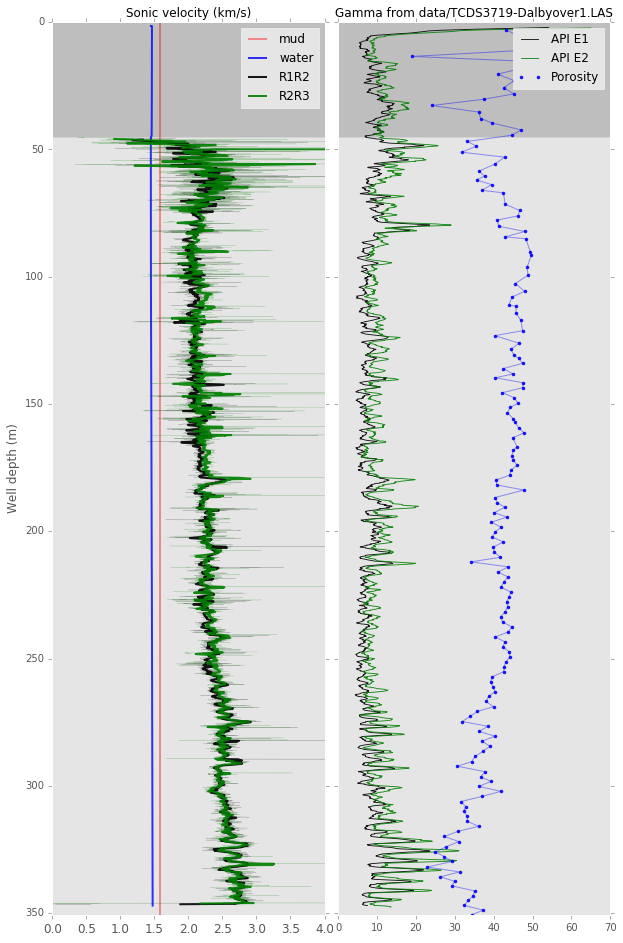

In [71]:
# Define functions
def well_plot(x,y=data['DEPTH'],label=None,lw=1,color='black',alpha=0.9):
    '''
    Using matplotlib to plot a well log. Defining a standard setup. 
    '''
    plt.plot(x,y,label = label,lw = lw, color=color, alpha=alpha)
    plt.ylim(max(data['DEPTH']),0)
    return

def casing_plot():
    '''
    Plot casing , label='casing'
    '''
    return plt.axhspan(0,casing, facecolor='k', alpha=0.17)

def smooth_filter(raw,kernel=60,med_kernel=3):
    '''
    Apply mean filter, set window size. Median filter removes spikes and outlayers
    '''
    raw = signal.medfilt(raw, kernel_size=med_kernel)
    return pd.rolling_mean(raw, kernel)

# Apply smoothing filter kernel is median window size,
kernel=60

fig = plt.figure(figsize=(10,16))
fig.subplots_adjust(wspace=0.05)

ax1 = plt.subplot(121)
ax1.set_ylim(ax1.get_ylim()[::-1]) 
plt.title('Sonic velocity (km/s)', fontsize = 12)
plt.ylabel('Well depth (m)', fontsize = 12)

#Plot mud velocity 5,300 feet/s
avg_temp = 0.5*(data['TEMP_E1']+data['TEMP_E2'])
plt.axvline(x=1.581, color='red', label='mud',lw=2,alpha=0.4)
plt.plot((1404.3+4.7*avg_temp+0.04*avg_temp**2)/1000,data['DEPTH'], lw=2, color='blue', label='water', alpha=0.8)

#well_plot(C*data['R1R2'],data['DEPTH']+0.1,'TEST!')

#Plot raw data
well_plot(data['R1R2'],data['DEPTH']+0.1, lw=0.3, alpha=0.3, label='')
well_plot(data['R2R3'],data['DEPTH']-0.1, lw=0.3, color='green', alpha=0.3,label='')
#R1R3

#Plot filtered data
well_plot(smooth_filter(C*data['R1R2'],kernel),data['DEPTH']+0.1, 
          label = 'R1R2',lw=2)
well_plot(smooth_filter(C*data['R2R3'],kernel),data['DEPTH']-0.1, 
          label = 'R2R3',lw=2, color='green')

casing_plot()

plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.xlim(0, 4)
plt.grid()
plt.legend()

# Plot gamma
ax2 = plt.subplot(122, sharey=ax1)
plt.title('Gamma from %s'%in_electric[0], fontsize = 12)
well_plot(smooth_filter(data['NGAM_E1'],101), lw=0.9, label='API E1')
well_plot(smooth_filter(data['NGAM_E2'],101), lw=0.9, color ='green', label='API E2')

plt.xlim(0, 30)
plt.ylim(max(data['DEPTH']),0)
plt.setp(ax2.get_yticklabels(), visible=False)
casing_plot()

# Plot porosity
mask = np.isfinite(data['POROSITY'])
plt.plot(100*data['POROSITY'][mask],data['DEPTH'][mask],'.b', alpha=0.9,label='Porosity')
plt.plot(100*data['POROSITY'][mask],data['DEPTH'][mask],'b-', alpha=0.4,label='')

plt.xlim(0, 70)
plt.ylim(max(data['DEPTH']),0)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.grid()
plt.legend()

plt.show()


This first look suggest a correlance of velocity peaks and gamma peaks with decreasing porosity at e.g. 50, 80, 170 and 190m. Also a general increasing velocity with depth and decreasing porosity. 

Velocity for [water](http://www.sciencedirect.com/science/article/pii/S030156299800091X) as a function of temperature is plotted in blue. 
Sonic velocities in drill mud is in the range of 185-189 $\mu/ ft$. See [Petrowiki](http://petrowiki.org/Porosity_evaluation_with_acoustic_logging). The lower value is typical for salt mud and showed as a red line in sonic plot.

## Gamma for correlance
TCDS3719-Dalbyover1.LAS and TCDS3719-Dalbyover2.LAS contains conductivity, temperature and gamma logs. However, as they are measured at different time and different directions, we can't be sure that the depth value is correct. 
A closer look at the gamma logs from all datasets in the range defined by variables top_row and bottom_row:

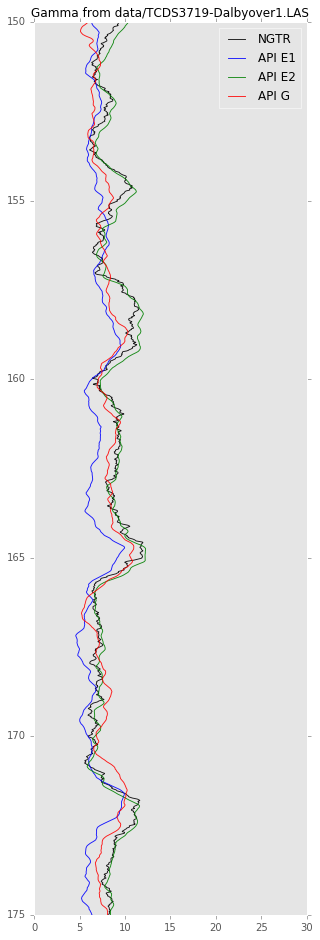

In [7]:
fig = plt.figure(figsize=(10,16))
fig.subplots_adjust(wspace=0.05)

top_row = 150
bottom_row = 175 

# Plot gamma
ax0 = plt.subplot(122, sharey=ax1)
plt.title('Gamma from %s'%in_electric[0], fontsize = 12)
well_plot(smooth_filter(data['NGTR'],101), lw=0.9, color ='black', label='NGTR')
well_plot(smooth_filter(data['NGAM_E1'],101), lw=0.9, color ='blue', label='API E1')
well_plot(smooth_filter(data['NGAM_E2'],101), lw=0.9, color ='green', label='API E2')
well_plot(smooth_filter(data['NGAM_G'],101), lw=0.9, color ='red', label='API G')

plt.xlim(0, 30)
plt.ylim(bottom_row,top_row)
plt.setp(ax2.get_yticklabels(), visible=False)
casing_plot()
plt.grid()
plt.legend()

plt.show()

How well does the gamma datasets correlate? For an ideal case, it would be the same value for both dataset to form a line with slope y=x, but the datasets are out of phase, noisy and have different measure factor. 

NameError: global name 'X' is not defined

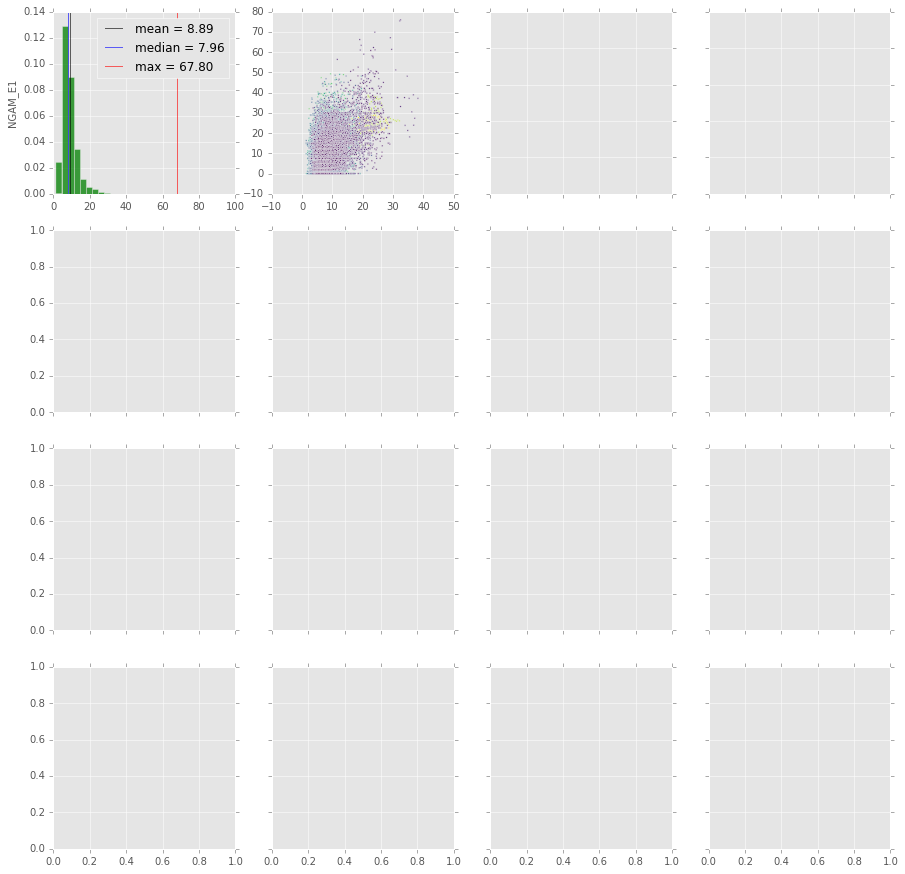

In [73]:
def corr_plot(x,y,ii,min_x=0,max_x=100,min_y=0, max_y=100, max_api_limit=100):
    '''
    Takes two columns in the data dataframe and produces a subplot with index ii. 
    Also calculates pearson correlation and fit a linear line to the dataset. 
    Use max_y and max_x to specify range of plots. max_api_limit crops out unrealistic high values. 
    Note that only points that occurs in both datasets are calculated.
    '''
    ax=plt.subplot(4, 4, ii)

    data[x][data[x] > max_api_limit] = np.nan #Remove values over max api limit
    data[y][data[y] > max_api_limit] = np.nan
    
    
    idx = np.isfinite(data[x]) & np.isfinite(data[y])
    if x!=y:    
        plt.scatter(data[x][idx], data[y][idx],c=color_depth[idx], s=10, marker='.', cmap='viridis_r', alpha = 0.95)

        #m,b = curve_fit(f, data[x][idx],data[y][idx])[0] # Least squares

        xd = data[x][idx]
        yd = data[y][idx]

        # determine best fit line
#        A = np.vstack([xd, np.ones(len(xd))]).T
#       slope, intercept = np.linalg.lstsq(A, yd)[0]
     
        slope, intercept, r_value, p_value, std_err = stats.linregress(xd,yd)
       
        xl = [min(xd), max(xd)]
        yl = [slope*xx + intercept  for xx in xl]

        # coefficient of determination, plot text
        variance = np.var(yd)
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
        Rsqr = np.round(1-residuals/variance, decimals=2)
    
        
        # error bounds
        yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)]
        par = np.polyfit(xd, yerr, 2, full=True)

        yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]
        yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]

#        plt.plot(xl, yl, '-g')
#        plt.plot(xd, yerrLower, '--g',alpha=0.6)
#        plt.plot(xd, yerrUpper, '--g',alpha=0.6)
        
    

    
        #####
        ax.text(10,90,'%s vs %s' %(x,y),fontsize=10,color='k')
        ax.text(10,80,'y=%.2fx+%.2f' %(slope,intercept),fontsize=10,color='k')
        ax.text(10,70,'r$^2$=%.3f'%data[x].corr(data[y])**2,fontsize=10,color='k') #pearson default
        ax.plot([min_x, max_x], [min_y, max_y], ls="--", c="green", alpha=0.1)
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)
    else:
        # the histogram of the data
        n, bins, patches = plt.hist(data[x][idx], 20, normed=1, facecolor='g', alpha=0.75)
        plt.xlim(0, 10+max(data[x][idx]))
        max_api=max(data[x][idx])
        mean_api=data[x][idx].mean()
        median_api=data[x][idx].median()
        
        plt.axvline(mean_api, c='k', label='mean = %.2f'% mean_api,lw=1,alpha=0.6)
        plt.axvline(median_api, c='b', label='median = %.2f'% median_api,lw=1,alpha=0.6)
        plt.axvline(max_api, c='r', label='max = %.2f'% max_api,lw=1,alpha=0.6)
        plt.xlim(min_x, max_x)
        plt.legend()
       
    if ii%4==1:
        plt.ylabel(i, fontsize = 10)
    if ii >= 13:
        plt.xlabel(j, fontsize = 10)
    # Plot background color from correlation
    return; 


data['NGAM_G'][data['NGAM_G'] > 100] = np.nan

fig,axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(15,15))

#fig.subplots_adjust(wspace=0.2, hspace=0.2)

#List correlation
gamma_corr = pd.concat([data['NGAM_E1'], data['NGAM_E2'], 
                        data['NGAM_G'], data['NGTR']], axis=1)

gamma_logs = ['NGAM_E1','NGTR','NGAM_G','NGAM_E2']
color_depth = data['DEPTH']

ii=0
for i in gamma_logs:   
        for j in gamma_logs:
            ii+=1
            corr_plot(i,j,ii)
            
plt.tight_layout()
plt.show()


One approach is to compare prominent peaks in the gamma to correlate the depth but in this tutorial I use a different approach. The datasets are crosscorrelated, slided in relation to each other, the sum of the two datasets for all depths are added to generate a peak for the best fit for the dataset as a whole. 

Gamma logs are used among other to correlate the datasets in depth. According to Kristian Sloth, the best dataset to trust is the TCDS3719-Dalbyover1.LASSee how correlated the gamma logs are:

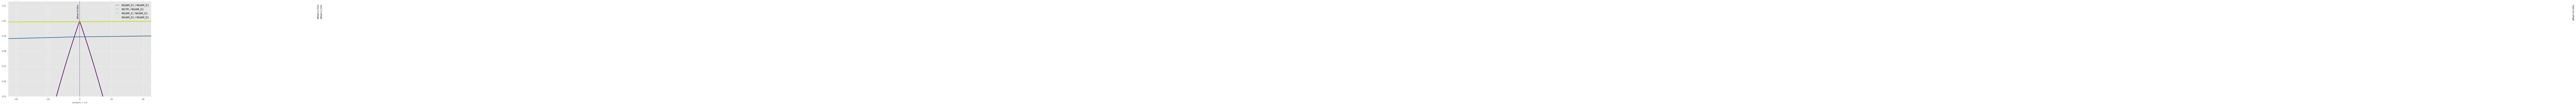

In [66]:
def cross_correlation(x1,x2,xc_type='same'):
    x1[np.isnan(x1)] = 0.
    x2[np.isnan(x2)] = 0.
    xc=np.correlate(x1, x2, xc_type)
    zero_offset = len(xc)/2
    xc/=max(xc)
    xx=np.arange(0,len(xc),1)-zero_offset
    offset =  xc.argmax(axis=0)-zero_offset
    return (pd.DataFrame(xc), pd.DataFrame(xx), offset, zero_offset)

# According to Kristian Sloth, the most reliable dataset 
ref='NGAM_E1'
ref_median = data['NGAM_E1'].median()

color=iter(cm.viridis(np.linspace(0,1,len(gamma_logs))))
for cross in gamma_logs:
    xc, xx, offset, zero_offset = cross_correlation(data[cross],data[ref])
    c=next(color)
    plt.plot(xx,xc,c=c, alpha=0.9,lw=3)
    plt.axvline(x=offset, c=c, label='%s / NGAM_E1'%cross,lw=1,alpha=0.8) 
    plt.text(offset-1.7,1.01,'offset=%.02fm'%(offset/100.),fontsize=10,color='k', rotation='vertical')

    xc_offset = np.roll(xc, -offset, axis=None)
#    plt.plot(xx,xc_offset,c='k', alpha=0.9,lw=3) 
    data[cross]= xc_offset
    
    
#    slices = xrange(0, len(data[cross]),len(data[cross])/n)
#    for depth_range in slices: 
#        print depth_range
   
# Find ref for well corelation    
plt.xlim(-45, 45)
plt.ylim(0.95, 1.013)
plt.autoscale(False)
plt.xlabel('samples = cm', fontsize = 10)
plt.legend()   

# Do new correlation scheme


With NGAM_E1 as reference, NGTR, and NGAM_G have a better match when 6 and 11 cm under. NGAM_E2 have a better fit when 9cm over the refernce level of NGAM_E1. 

We can also split the data and look at segments of the line to correct for varying misfit of the data. This might not be a large issue in such a short wireline, but for a longer and tight boreholes it cxan be a serious issue. 

Following code split the datasets in slices (set global variable n) and crosscorrelate every slice seperatly:

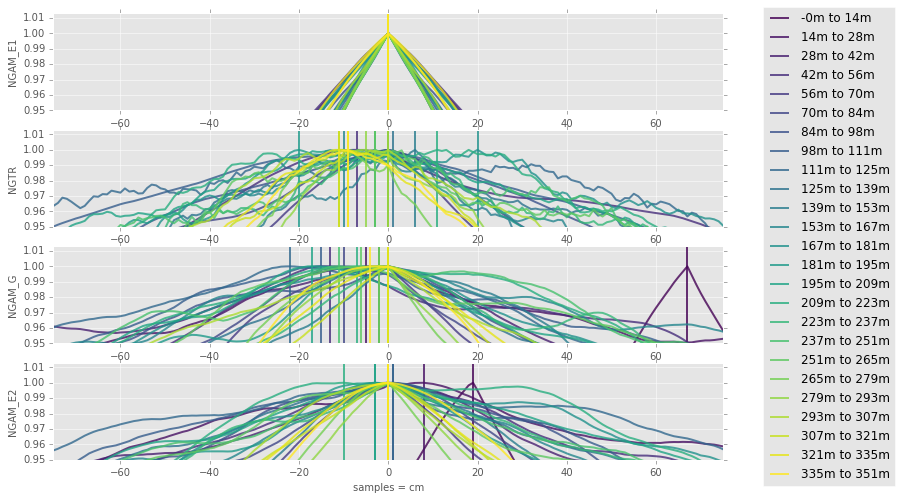

In [10]:
# Number of slices
n = 25

# Reference
ref_slices = np.array_split(data[ref], n)

# Make depth segments
depth_slices = np.array_split(data['DEPTH'], n)
color=iter(cm.viridis(np.linspace(0,1,n)))
offset_array = np.zeros((n, len(gamma_logs)))

ii=0
for i in gamma_logs:   
    ii+=1       
    cross_slices = np.array_split(data[i], n)
    color=iter(cm.viridis(np.linspace(0,1,n)))
    for slice_index in xrange(0,n):
            ax1=plt.subplot(4, 1, ii)
            c=next(color)
            xc_slice, xx_slice, offset_slice, zero_offset_slice = cross_correlation(cross_slices[slice_index],ref_slices[slice_index])
            plt.plot(xx_slice,xc_slice,c=c, alpha=0.8,lw=2,
                     label='%.0fm to %.0fm' %(min(depth_slices[slice_index]),max(depth_slices[slice_index])))
            
            plt.axvline(x=offset_slice, c=c,lw=2,alpha=0.8)
            offset_array[slice_index,ii-1] = offset_slice
            
#            plt.text(offset_slice-1.7,1.01,'depth=%.0fm'%(min(depth_slices[slice_index])),fontsize=10,color=c, rotation='vertical')
#            plt.text(offset_slice-1.7,1.01,'depth=%.0fm'%(min(depth_slices[slice_index])),fontsize=10,color='k', rotation='vertical')
            plt.xlim(-75, 75)
            plt.ylim(0.95, 1.013)
            plt.ylabel(i, fontsize = 10)
              
plt.autoscale(False)
plt.xlabel('samples = cm', fontsize = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 2.2))

#print offset_array

We see that the uppermost slice has a misfit, but the difference decrease with depth, maybe with higher weight and tension. It's also possible that the casing and the soft chalk in the upper part cause depth errors. We also see that ther NGTR data is more noisy than NGAM_E2 (electric) or NGAM_G (induction). Variations in the Q-value of the NGAM_E1 correlated with itself indicates higher frequency in variations for some depth slices. The misfit over depth: 

(350.63, 0)

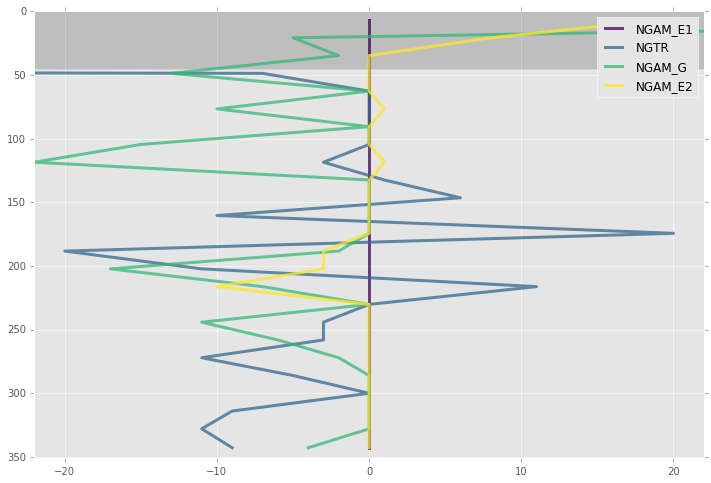

In [14]:
# Make depth slices in metres
depth_slices = np.array_split(data['DEPTH'], n)
depth_array = np.zeros(n)

for i in xrange(0,len(depth_slices)):
    depth_array[i] = (min(depth_slices[i]) + max(depth_slices[i]))/2

color=iter(cm.viridis(np.linspace(0,1,len(gamma_logs))))
for i in xrange(0,len(gamma_logs)):
    c=next(color)
    plt.plot(offset_array[:,i],depth_array,c=c, alpha=0.75,lw=3, label=gamma_logs[i])

plt.legend()   

casing_plot()
plt.xlim(-22, 22)
plt.ylim(max(data['DEPTH']),0)


Shows that the misfit varies from about -20 to 20 cm in relation to reference (NGAM_E1). The large error in uppermost section is believed to be errors from the logs. Variation over depth depends on the relation of NGAM_E! and the other logs. One could think, e.g, that the DEPTH log for TCDS3719 is some 10 cm wrong around 240m depth. 

1
NGAM_E1 NGAM_E1
<type 'str'>
<type 'str'>
<type 'str'>


TypeError: Not implemented for this type

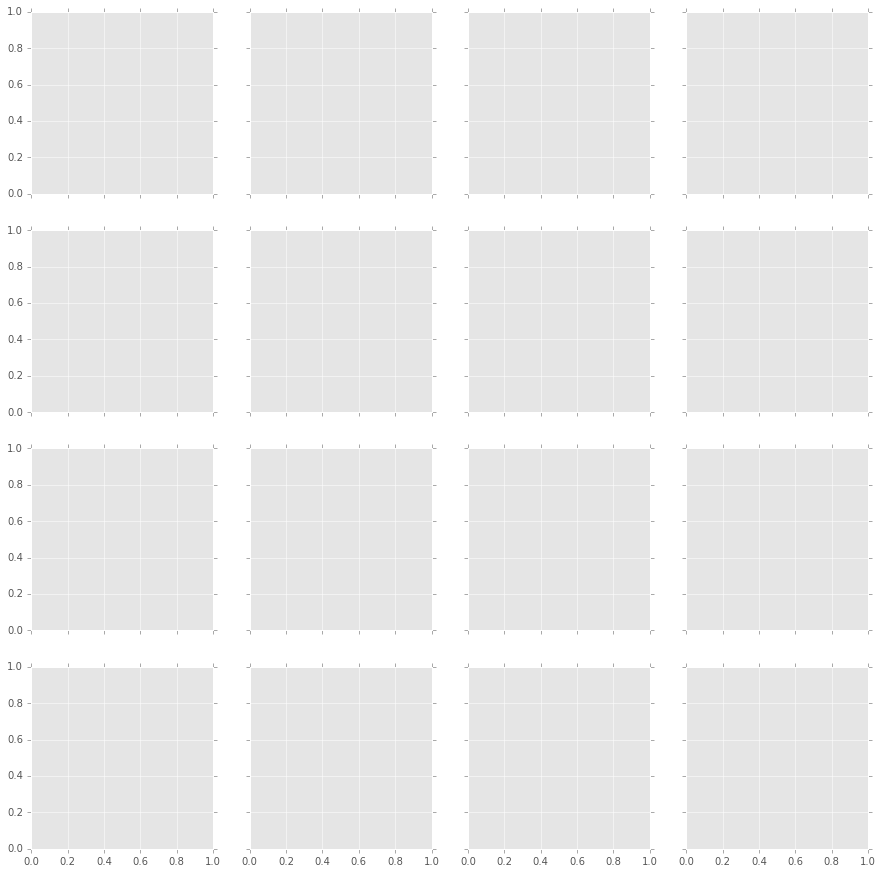

In [15]:
data['NGAM_G'][data['NGAM_G'] > 100] = np.nan

fig,axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(15,15))

#fig.subplots_adjust(wspace=0.2, hspace=0.2)

#List correlation
gamma_corr = pd.concat([data['NGAM_E1'], data['NGAM_E2'], 
                        data['NGAM_G'], data['NGTR']], axis=1)

gamma_logs = ['NGAM_E1','NGTR','NGAM_G','NGAM_E2']
color_depth = data['DEPTH']

ii=0
for i in gamma_logs:   
        for j in gamma_logs:
            ii+=1
            print ii
            print i, j
            print type(i)
            print type(j)
            print type(ref)
            xi, xx, offset, zero_offset = cross_correlation(ref,i)
            xj, xx, offset, zero_offset = cross_correlation(ref,j)
            print type(xj)
            print type(xi)
            print offset

            corr_plot(xi,xj,ii)
             
plt.tight_layout()
plt.show()

The gamma logs for electric logs correlates somehow (0.81), and we can assume that the logs are adjusted correctely 

in depth. The gamma logs for correlation is corrected for dc by subtraction of the median value. Hoverver NGAM_G and NGTR are not correlated at all, but a moderate low-pass filter shows that it's a minor phase shift:

In [ ]:
fig = plt.figure(figsize=(15,5))

ax0 = plt.subplot(121)
plt.plot(data['NGTR'],data['NGAM_G'], '.k', label = 'NGTR vs NGAM_G', alpha = 0.5, markersize=3,markevery=1)
plt.legend()
plt.xlabel('NGTR', fontsize = 12)
plt.ylabel('NGAM_G', fontsize = 12)
plt.plot([-75, 75], [-75, 75], ls="--", c=".3")
plt.xlim(0, 50)
plt.ylim(0, 50)

ax1 = plt.subplot(122)
plt.plot(smooth_filter(data['NGTR'],7),smooth_filter(data['NGAM_G'],7), '.k', label = 'NGTR vs NGAM_G \n with filter', alpha = 0.5, markersize=3,markevery=1)
plt.legend()
plt.xlabel('NGTR, filtered', fontsize = 12)
plt.ylabel('NGAM_G, filtered', fontsize = 12)
plt.plot([-75, 75], [-75, 75], ls="--", c=".3")
plt.xlim(0, 50)
plt.ylim(0, 50)

cbar=plt.colorbar(por_per)
cbar.solids.set_rasterized(True) 
cbar.ax.invert_yaxis() 
plt.show()

It apears that there is a rather good correlance between the electric logs, but not between electric and sonic log, especially for lower values. 

## Inspect and interpolate plug sample data (porosity and permeability)

The plug samples hare used for porosity and pereability. The samples are interpolated and filtered as:

In [ ]:
fig = plt.figure(figsize=(16,12))
fig.subplots_adjust(wspace=0)

ax1 = plt.subplot(121)
mask_POR = np.isfinite(data['POROSITY'])
plt.plot(data['POROSITY'][mask_POR],data['DEPTH'][mask_POR],'.k', alpha=0.9,label='Porosity')
POR_inter = data['POROSITY'].interpolate(method='linear', order=2,limit=300, limit_direction='both')
plt.plot(POR_inter,data['DEPTH'],'k-', alpha=0.3)
#plt.xlim(-2,15)
plt.plot(smooth_filter(POR_inter,2),data['DEPTH'],'k-', alpha=0.8)
plt.ylim(max(data['DEPTH']),0)
casing_plot()
plt.legend()
plt.ylim(max(data['DEPTH']),0)

ax2 = plt.subplot(122)
mask_PERM = np.isfinite(data['PERMEABILITY'])
plt.plot(1000*data['PERMEABILITY'][mask_PERM],data['DEPTH'][mask_PERM],'.b', alpha=0.9,label='Permeability')
PERM_inter = data['PERMEABILITY'].interpolate(method='linear', order=2,limit=300, limit_direction='both')
plt.plot(1000*PERM_inter,data['DEPTH'],'b-', alpha=0.3)
plt.xlim(-2,15)
plt.plot(smooth_filter(1000*PERM_inter,2),data['DEPTH'],'b-', alpha=0.8)
plt.xlabel('mD', fontsize = 12)

casing_plot()
plt.legend()
plt.ylim(max(data['DEPTH']),0)

plt.show()


Continous datasets are saved in new arrays, inter_POR and inter_PERM.

## How would the data relate to classification and literature?

Porosity and permeability can indicate lithology, as shown by Akbar et al (1995),  based on R.Nurmi (1986):

<img src="images/Akbar_et_al.png" alt="Drawing" style="width: 400px;"/>

And ploted with plug data:

In [ ]:
PERM_inter = data['PERMEABILITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')
POR_inter = data['POROSITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')

fig = plt.figure(figsize=(12,8))
ax = plt.gca()

mask_POR = np.isfinite(data['POROSITY'])
color_depth = data['DEPTH'][mask_POR]
#cm = plt.cm.get_cmap('RdYlBu')

por_per = ax.scatter(100*data['POROSITY'][mask_POR], 1000*data['PERMEABILITY'][mask_POR], 
                     c=color_depth, s=120, label='Plug samples', cmap='viridis_r', alpha=0.9)
ax.set_yscale('log')
cbar=plt.colorbar(por_per)
cbar.solids.set_rasterized(True) 
cbar.ax.invert_yaxis() 
plt.xlabel('Por (%)', fontsize = 12)
plt.ylabel('Perm (mD)', fontsize = 12)
plt.xlim(-4, 52)
plt.ylim(0.001, 1100)
plt.legend()
legend = ax.get_legend()
legend.legendHandles[0].set_color('grey')

im = plt.imread('images/Akbar_et_al.png')
plt.imshow(im, extent=[-4.5, 31.4, 0.002, 1500],interpolation='bicubic')

plt.show()

## Make plot of electric data

Now a better look at the electric data:

In [ ]:
# Apply smoothing filter kernel
kernel=20

fig = plt.figure(figsize=(14,18))
fig.subplots_adjust(wspace=0.025)
plt.xticks(rotation='vertical')
plt.figtext(.1, .04, 'E1 = %s Fluid probe with casing \nE2 = %s Fluid probe \n G = %s Induction probe'%(in_electric[0],in_electric[1],in_gamma))

#Depth
ax0 = plt.subplot(181) 
well_plot(data['DEPTH'],data['DEPTH'], lw=0.1, alpha=0.0)
plt.ylabel('Well depth (m)', fontsize = 12)
plt.title('Depth \n m', fontsize = 12)
casing_plot()
ax0.axes.get_xaxis().set_visible(False)
plt.yticks(np.arange(0, max(data['DEPTH']), 25.0))
ax0.text(15, 20, 'Casing', fontsize=10,color='k')


#Gamma NG TCDS og NG casing
ax1 = plt.subplot(172)
well_plot(data['NGAM_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'green', label='E1')
well_plot(data['NGAM_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E2')
plt.title('Gamma \n (API)', fontsize = 12)
plt.xlim(0, 50)
ax1.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#Natural Gamma
ax2=plt.subplot(173)
well_plot(data['NGAM_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'green', label='G')
plt.title('Gamma \n (API)', fontsize = 12)
plt.xlim(0, 50)
ax2.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#Temp
ax3=plt.subplot(174)
well_plot(data['TEMP_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E1')
well_plot(data['TEMP_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'magenta', label='E2')
plt.title('Fluid Temp \n C', fontsize = 12)
plt.xlim(8, 15)
ax3.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#fluid conductivity
ax4=plt.subplot(175)
well_plot(10000*data['COND_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E1')
well_plot(10000*data['COND_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'magenta', label='E2')
# in casing...
plt.title('Fluid EC \n mS/m', fontsize = 12)
ax4.set_xscale('log')
plt.xlim(0, 50000)
ax4.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#formation conductivity
ax5=plt.subplot(176)
well_plot(1000*data['COND_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='G')
plt.title('Form Cond \n mS/m', fontsize = 12)
plt.xlim(0, 1000)
ax5.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#R
ax6=plt.subplot(177)
well_plot(1/data['COND_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'purple', label='G')
plt.title('Resistiv Chalk \n Ohmm', fontsize = 12)
ax6.set_xscale('log')
plt.xlim(0, 100)
ax6.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

plt.setp(ax1.get_xticklabels(), fontsize=12)

plt.show()


## Make conversions, some theory

We can get some relations in place: 

Formation factor can be estimated in two ways; from porosity and cementation and from conductivity measurements, see e.g. [this](https://github.com/TobbeTripitaka/Dalbyover/tree/master/ref) and [Olsen, 2008](https://github.com/TobbeTripitaka/Dalbyover/blob/master/ref/Olsen%20et%20al%202008.pdf): 

$$F=\frac{R_O}{R_W}=\frac{a}{\phi^m}=\frac{\tau}{\phi}$$

Where F is formation factor, $R_O$ is resistivity of rock and $R_W$ is resistivity of porefluid. $\phi$ is porosity and $m$ is the curious cementation factor that will be discussed later. $a$ is usuallly set to 1. $\tau$ is $L/L_a$.

We can solve for m:

$$m = \frac{ln(\frac{a*R_W}{R_O})}{ln \phi}$$

With this information we can involve Archie's law and try to model the porosity based on electric logs, parameters and plug samples. 

$$C_t = \frac{1}{a} C_w \phi^m S_w^n$$

$C_t$ is the electrical conductivity of the fluid saturated rock
$a$ is the Tortuosity factor
$C_w$ is the electrical conductivity of the brine
$\phi$ is the porosity
$m$ is the cementation exponent
$S_w$ is the brine saturation
$n$ is saturation exponen

Kozeny’s equation relates porosity. permeability and pore space as (Kozeny, 1927): 

$$k=c \frac{\phi}{s^2}$$

and Carman’s model for the tortuous path (Carman, 1937):

$$c_R=\frac{1}{k_0\tau}$$

where $k_0$ is close to 2. See e.g. [Katika and Fabricius](https://github.com/TobbeTripitaka/Dalbyover/blob/master/ref/AB_KK20141212-RADE8316.pdf) for comments and applications (but look out for typos in formulas!). 

Kozeny’s factor ($c$) is often assumed to be 0.25, but it might actually be related to the porosity and geometry of the rock. The model from [Mortensen et. al. (1998)](https://github.com/TobbeTripitaka/Dalbyover/blob/master/ref/Mortensen-et-al%201998.pdf) connects Kozeny’s factor with porosity for chalk depending on shape. For circular cavities:

$$c_\phi=(4\cos(\frac{1}{3}\arccos(\phi\frac{8^2}{\pi^3}-1)+\frac{4}{3}\pi)+4)^{-1}$$

but with square tubes $c_\phi$ would rather be: 

$$c_\phi=(4\cos(\frac{1}{3}\arccos(\phi*2-1)+\frac{4}{3}\pi)+4)^{-1}$$

Klinkenberg permeability is estimated from gas permeability as:

$$K_k=0.52K_a^{1.083}$$
 
Conductivity/resistivity measurements must also be corrected for temperature. It's not clear if this is done for the dataset and should be tried and known as a posible source of error. An empirical conversion can be made with Hilchie’s equation:

$$R_{WT2}=R_{WT1}\frac{T1+X}{T2+X}$$ and where $$ X=10^{-0.340396 \log_{10} R_{WT1} − 0.641427}$$

In [ ]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

# Equations
# Klinkenberg
klinkenberg = lambda k: 0.52*k**1.083

#Mortensen circular (1) and square (2)
mortensen1 = lambda c_phi: 1./(4*math.cos((1./3)*math.acos(c_phi*64/(math.pi**3)-1)+4*math.pi/3)+4)
mortensen2 = lambda c_phi: 1./(4*math.cos((1./3)*math.acos(c_phi*2-1)+4*math.pi/3)+4)

# Hilchie. Set reference sample
def hilchie(r_array, t_array, R1, T1):
    H = 10.**(-0.340396*math.log10(R1)+0.641427)
    return r_array*(T1+H)/(t_array+H)
    
#Plot exemples
ax1 = plt.subplot(2, 2, 1)
plt.title('Klinkenberg permeability', fontsize = 12)
per_range = np.arange(0, 0.1, 0.0001)
klinkenberg_range = np.array([klinkenberg(c) for c in per_range])
klinkenberg_samples = np.array([klinkenberg(c) for c in data['PERMEABILITY'][mask_PERM]])
plt.plot(1000*per_range,1000*klinkenberg_range,'g',lw=2,label="Klinkenberg relation")
plt.plot(1000*data['PERMEABILITY'][mask_PERM],1000*klinkenberg_samples,'.b', markersize=8, alpha = 0.4,label="Samples")
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.legend(loc=2)
plt.ylabel('Klinkenberg permeability, $K_K$ (mD)', fontsize = 12)
plt.xlabel('air-permeability, $K_a$ (mD)', fontsize = 12)

ax2=plt.subplot(2, 2, 2)
plt.title('Mortensen cementation factor from porosity', fontsize = 12)

por_range = np.arange(0, 0.95, 0.01)
mortensen1_range = np.array([mortensen1(c) for c in por_range])
mortensen2_range = np.array([mortensen2(c) for c in por_range])
plt.plot(por_range,mortensen1_range,'b',lw=2,label="Mortensen circular")
plt.plot(por_range,mortensen2_range,'g',lw=2,label="Mortensen square")
plt.ylabel("Kozeny's factor", fontsize = 12)
plt.xlabel('Porosity', fontsize = 12)
plt.legend(loc=2)
klinkenberg_perm = np.array([klinkenberg(c) for c in PERM_inter])
Kozeny_factor = np.array([mortensen1(c) for c in (0.01*POR_inter)])

ax3=plt.subplot(2, 2, 3)
plt.title("Hilchie's resistivity conversion", fontsize = 12)
res_in = np.arange(10, 100, 1, dtype=np.float) 
t_step_array=np.ones_like(res_in)
hilchie_temps = np.arange(5,17,1, dtype=np.float) # Plot temperatures
color_idx = np.linspace(0, 1, len(hilchie_temps))

ref_D = 5
R1= 70
T1 = 6

for i, T2 in zip(color_idx, hilchie_temps):
    hilchie_range = hilchie(res_in, t_step_array*T2, R1, T1)
    ax3.plot(res_in, hilchie_range, color=plt.cm.winter(i) ,lw=0.5)
    ax3.text(101, hilchie(100,T2,R1,T1), str(T2)+'$^\circ$', fontsize=9, color=plt.cm.winter(i))
    if T1 == T2:
        ax3.scatter(R1,hilchie(R1,T1,R1,T1),color=plt.cm.winter(i),marker='.', s=150, label='Reference')
        ax3.text(R1-32,hilchie(R1,T1,R1,T1)+8, '(%s $\Omega m$, %s$^\circ C$ )'%(R1, T1), fontsize=10, color='b')

ax3.plot(res_in+10000,hilchie_range,'g',lw=0.3, label='Temperature, C')
ax3.legend(loc=2)
plt.ylabel('Hilchie corrected Resistivity', fontsize = 12)
plt.xlabel('Measured resistivity', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 120)

#Correct Data:
klinkenberg_inter = np.array([klinkenberg(c) for c in PERM_inter])

#    ref_index = (data['DEPTH']==ref_D).argmax()
#    R1=r_array[ref_index]
#    T1 = t_array[ref_index]
#for electric in ['E1','E2','G']:
#    data['RES_'+electric +'_hilchie'] = 1/np.array([hilchie(t) for t in data['COND_' + electric]])

#data[] = np.array([klinkenberg(c) for c in PERM_inter])
#klinkenberg_inter = np.array([klinkenberg(c) for c in PERM_inter])
#klinkenberg_inter = np.array([klinkenberg(c) for c in PERM_inter])

plt.show()


## Cross-plot data

Look at relation Resistivity Formation Factor vs porosity. 

NameError: name 'POR_inter' is not defined

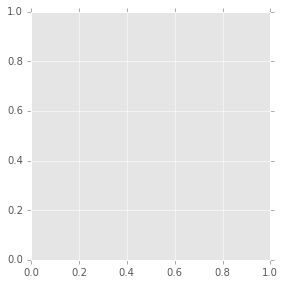

In [26]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

ax1 = plt.subplot(2, 3, 1)
ax1.scatter(100*POR_inter, 1000*PERM_inter, c=data['DEPTH'], cmap='winter_r', s=10, alpha = 0.6,marker='.',edgecolors='none')
ax1.set_yscale('log')
plt.ylabel('Permeability (mD)')
plt.xlabel('Porosity (%)')
plt.xlim(0, 60)

ax4 = plt.subplot(2, 3, 4)
ax4.scatter(1000*data['COND_G'], 1000*PERM_inter, c=data['DEPTH'], cmap='winter_r', s=10, alpha = 0.6,marker='.',edgecolors='none')
ax4.set_xscale('log')
ax4.set_yscale('log')
plt.ylabel('Permeability (mD)')
plt.xlabel('Formation Conductivity (mS/m)')

ax2 = plt.subplot(2, 3, 2)
ax2.scatter(100*POR_inter, 1000*data['COND_G'], c=data['DEPTH'], cmap='winter_r', s=10, alpha = 0.6,marker='.',edgecolors='none')
ax2.set_yscale('log')
plt.ylabel('formation conductivity (mS/m)')
plt.xlabel('Porosity (%)')
plt.xlim(0, 60)

ax5 = plt.subplot(2, 3, 5)
ax5.scatter(100*POR_inter, 1000*data['COND_E2'], c=data['DEPTH'], cmap='winter_r', s=10, alpha = 0.6,marker='.',edgecolors='none')
ax5.set_yscale('log')
plt.ylabel('Formation conductivity (mS/m)')
plt.xlabel('Porosity (%)')
plt.xlim(0, 60)

#Sea water http://www.lenntech.com/applications/ultrapure/conductivity/water-conductivity.htm
ax5.axhline(y=5000,xmin=0,xmax=100,c="blue",linewidth=0.5,zorder=0, label='Sea water')
ax5.text(1.5, 2200, 'Brine?', fontsize=10,color='k')
ax5.text(1.5, 60, 'Fresh water?', fontsize=10,color='k')
ax5.text(1.5, 3, 'Dry?', fontsize=10,color='k')

r_f_factor = data['COND_G']/data['COND_E1']

ax3 = plt.subplot(2, 3, 3)
ax3.scatter(100*POR_inter, r_f_factor, c=data['DEPTH'], cmap='winter_r', s=10, alpha = 0.6, marker='.',edgecolors='none')
ax3.set_yscale('log')
plt.ylabel('Resistivity Formation Factor')
plt.xlabel('Porosity (%)')
plt.xlim(0, 60)
#plt.ylim(-1, 1)

ax6 = plt.subplot(2, 3, 6)
ax6.scatter(1000*data['COND_G'], 1000*data['COND_E2'],c=data['DEPTH'], cmap='winter_r', s=10, alpha = 0.6, marker='.',edgecolors='none')
ax6.set_xscale('log')
ax6.set_yscale('log')
plt.xlabel('Formation conductivity (mS/m)')
plt.ylabel('Fluid conductivity (mS/m)')

ax6.axhline(y=5000,c="blue",linewidth=0.5,zorder=0, label='Sea water')
ax6.axvline(x=5000, c="blue",linewidth=0.5,zorder=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

cbar=plt.colorbar(por_per, cax=cbar_ax)
cbar.ax.invert_yaxis() 

plt.show()

## Formation factor from various sources, estimating cementation factor (m)

Plots showing:

1a Formation factor, calculated from Archie's law, see e.g. [this](https://github.com/TobbeTripitaka/Dalbyover/blob/master/ref/Chapter%2017.PDF)

1b Formation factor from porosity. See e.g. [Akbar et al 1995](https://github.com/TobbeTripitaka/Dalbyover/blob/master/ref/Akbar%20et%20al%201995.pdf)

1c The Soft Formation Formula, when m is not availble. See [this](https://github.com/TobbeTripitaka/Dalbyover/blob/master/ref/Chapter%2017.PDF)

2 How Formation factor from conductivity and porosity differs

3 How a varying cementation factor $m$, could correct the difference

$S_W$ can be calculated from: 

$$S^n_W=\frac{a}{\phi^m}\frac{R_W}{R_t}$$




In [ ]:
fig = plt.figure(figsize=(12,15))
fig.subplots_adjust(wspace=0.0)
plt.xticks(rotation='vertical')

#plt.figtext(.1, .05, 'E1 = %s Fluid probe with casing \nE2 = %s Fluid probe \n G = %s Induction probe'%(in_electric[0],in_electric[1],in_gamma))

#Cementation factor
m=2
a=1 #a-factor is close to unity as expected for a sediment with small clay content and a low BET value

resistivity_fluid = 1/data['COND_E2'] #TCDS3719
resistivity_chalk = 1/data['COND_G'] #INDG1832

#Formation factors
ax0 = plt.subplot(131)
Ff0 = resistivity_chalk/resistivity_fluid #See text
Ff1 = a/(POR_inter**m) #Known porosity! See text
Ff2 = 0.81*(POR_inter)**-2 #Known porosity! See text
well_plot(Ff0,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='Archie F from cond')
well_plot(Ff1,data['DEPTH'], lw=1, alpha=0.9, color= 'brown', label='Archie F from $\phi$')
well_plot(Ff2,data['DEPTH'], lw=1, alpha=0.5, color= 'purple', label='SFF')
plt.title('Formation factor', fontsize = 12)
plt.xlim(0, 20)
plt.legend()
casing_plot()

ax1 = plt.subplot(132) 
plt.title('Formation factor \n Difference', fontsize = 12)
diff_form=Ff0-Ff1
ax1.fill_betweenx(data['DEPTH'],diff_form,color= 'red',label='Difference')
ax1.axes.get_yaxis().set_visible(False)
plt.xlim(-18, 18)
plt.ylim(max(data['DEPTH']),0)
casing_plot()

ax2 = plt.subplot(133) 
plt.title('Cementation factor \n to fit formation factors', fontsize = 12)
m_form=(np.log(a*resistivity_fluid/resistivity_chalk))/(np.log(POR_inter))
well_plot(m_form,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='m')

ax2.axes.get_yaxis().set_visible(False)
plt.xlim(-2, 3)
casing_plot()
plt.legend()

plt.show()

Down to 130m we get unrealistic values of $m$.  For depth above 100m it's far off. This is probably related to water saturation variations, $S_W$  and variations in salinity. In the upper part we might have a freshwater aquifer but at a larger depth, maybe from 140m, there might be fossile brine. This is a probable suggestion from the E2 conductivity log. 

## Specific surface and permeability from electric logs

The decreaseing cementation factor from 250m follows decreasing porosity according to e.g. Borai (1987). 

Now we can estimate specific surface square and from C = 0.25 or Mortensens formulas and measured porosity we can calculate k and compare with measurements. We can also calculate $\tau$ and compare calculated permeability with measurements. 


In [ ]:
fig = plt.figure(figsize=(14,15))
fig.subplots_adjust(wspace=0.0)
plt.xticks(rotation='vertical')

ax0 = plt.subplot(141)
c=0.25
plt.title('$S^2$', fontsize = 12)
mortensen_c1 = np.array([mortensen1(POR_mort) for POR_mort in POR_inter])
surface_form_mortensen = (mortensen_c1*(POR_inter**3)/klinkenberg_inter)
surface_form_stat = (c*(POR_inter**3)/klinkenberg_inter)
well_plot(surface_form_stat,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='specific surface \n static c= %s'%c)
well_plot(surface_form_mortensen,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='specific surface \n c Mortensen')
casing_plot()
plt.legend()

ax1 = plt.subplot(142)
plt.title("Kozeny's factor", fontsize = 12)
k2_inter=(mortensen_c1*POR_inter**3)/(surface_form_mortensen*(1-POR_inter)**2)
k1_inter=mortensen_c1*POR_inter/surface_form_mortensen

well_plot(k1_inter,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='$k=c*\phi^3/(s^2*(1-\phi)^2)$')
well_plot(k2_inter,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='$k=c*\phi/s^2$')
#well_plot(data['PERMEABILITY'][mask_PERM],data['DEPTH'][mask_PERM], lw=1, alpha=0.9, color= 'red', label='Samples')
ax1.set_xscale('log')
ax1.axes.get_yaxis().set_visible(False)
casing_plot()
plt.legend()

ax2 = plt.subplot(143)
plt.title('$ tau $', fontsize = 12)
tau = Ff0*POR_inter
well_plot(tau,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='$tau$')
ax2.axes.get_yaxis().set_visible(False)
casing_plot()
plt.legend()

ax3 = plt.subplot(144)
plt.title('$k$', fontsize = 12)
k_final = (mortensen_c1*POR_inter)/(tau*surface_form_mortensen)
well_plot(k_final,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='k')
ax3.scatter(data['PERMEABILITY'][mask_PERM],data['DEPTH'][mask_PERM],color='green',marker='.',label='Samples')
ax3.axes.get_yaxis().set_visible(False)
casing_plot()
plt.legend()
ax3.set_xscale('log')


plt.legend()

The difference between measured permeability and permeability estimated from porosity and resistivity is used to estimate a correct $\tau$ for the unsaturated zone: 

In [ ]:
fig = plt.figure(figsize=(14,15))
fig.subplots_adjust(wspace=0.0)
plt.xticks(rotation='vertical')

ax0 = plt.subplot(131)
plt.title('Permeability \n Difference', fontsize = 12)
diff_perm=PERM_inter-k_final
ax0.fill_betweenx(data['DEPTH'],diff_perm,color= 'red',label='Difference')
ax0.axes.get_yaxis().set_visible(False)
#ax0.set_xscale('log')
plt.xlim(-0.5, 0.2)
plt.ylim(max(data['DEPTH']),0)
casing_plot()
plt.legend()

ax1 = plt.subplot(132)
plt.title('$ tau $', fontsize = 12)
tau = Ff0*POR_inter
tau_corrected = (mortensen_c1*POR_inter)/(PERM_inter*surface_form_mortensen)
well_plot(tau,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='$tau$')
well_plot(tau_corrected,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='$tau$ corrected')
ax1.axes.get_yaxis().set_visible(False)
casing_plot()
plt.legend()


It appears that the permeability calculations are rather correct in the saturated zone, 

In [ ]:
#Archie's porosity

#ax1 = plt.subplot(132)
#Ct = data['COND_E2']
#a = 0.6 # Find for chalk
#Cw = data['COND_E1']
#m = 2.36 # Check Olsen paper, Witthüser  et al: 2.36
#Sw = 1 # Find temperature formula
#n = 2 #Wettability

#Interpolated plug data
#ax0 = plt.subplot(131)
#mask_POR = np.isfinite(data['POROSITY'])
#plt.plot(data['POROSITY'][mask_POR],data['DEPTH'][mask_POR],'.b', alpha=0.9,label='Porosity from plugs')
#plt.plot(POR_inter,data['DEPTH'],'b-', alpha=0.3)
#well_plot(smooth_filter(POR_inter,500),data['DEPTH'], alpha=0.8,color= 'blue')
#plt.grid()
#plt.legend()
#casing_plot()
#
#Archies_porosity =(Ct*a/(Cw*Sw**n)**(1/m))
#well_plot(Archies_porosity,color='k', label='Porosity')
#
#ax1.axes.get_yaxis().set_visible(False)
#plt.grid()
#plt.legend()
#casing_plot()


#Archies porosity with samples and differences
#ax2 = plt.subplot(133)
#ax2.axes.get_yaxis().set_visible(False)
#plt.grid()
#plt.legend()
#casing_plot()

#surface_from_cond = resistivity_fluid/((POR_inter**m_form)*resistivity_chalk)
#well_plot(surface_from_cond,data['DEPTH'], lw=1, alpha=0.9, color= 'red', label='specific surface \n from conductivity')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(5)
x, y = np.random.random((2,500))

fig, ax = plt.subplots()
ax.plot(x, y, 'bo')

# The key option here is `bbox`. I'm just going a bit crazy with it.
ax.annotate('Something', xy=(x[0], y[0]), xytext=(-20,20), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))



plt.show()

In [ ]:
x = 'NGAM_E1'
y = 'NGAM_G'

idx = np.isfinite(data[x]) & np.isfinite(data[y])

xi = data[x][idx]
#A = array([ xi, ones(9)])
# linearly generated sequence
y = data[y][idx]

slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)

print 'r value', r_value
print  'p_value', p_value
print 'standard deviation', std_err


fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(wspace=0.2)

ax1 = plt.subplot(121)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
print intercept
line = slope*xi+intercept

plt.plot(xi,y,'ro')
plt.plot(xi,line,'k-')
plt.xlim(0, 90)
plt.ylim(0, 90)

print 'r value', r_value
print  'p_value', p_value
print 'standard deviation', std_err



ax2 = plt.subplot(122)
slope, intercept, r_value, p_value, std_err = stats.linregress(y,xi)
print intercept
line = slope*xi+intercept

plt.plot(y,xi,'bo')
plt.plot(xi,line,'k-')


print 'r value', r_value
print  'p_value', p_value
print 'standard deviation', std_err

plt.xlim(0, 90)
plt.ylim(0, 90)




show()

In [ ]:
from scipy import stats
import numpy as np
x = np.random.random(100)
y = np.random.random(100)-0.5
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,y,'bo')
plt.plot(y,x,'ro')

x_corr = [min(x), max(x)]
y_corr = [slope*xx + intercept  for xx in x]

plt.plot(x_corr, y_corr, '-g')



print "r-squared:", r_value**2
print "intercept:", intercept

In [27]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# draw coastlines.
m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='coral',lake_color='aqua')
plt.show()

ImportError: No module named basemap

In [63]:
a = np.arange(6)
print a
b = np.roll(a,1)
print b

c = np.roll(a,-1)
print c

[0 1 2 3 4 5]
[5 0 1 2 3 4]
[1 2 3 4 5 0]


In [76]:
import numpy as np
import random

# m denotes the number of examples here, not the number of features
def gradientDescent(x, y, theta, alpha, m, numIterations):
    xTrans = x.transpose()
    for i in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        # avg cost per example (the 2 in 2*m doesn't really matter here.
        # But to be consistent with the gradient, I include it)
        cost = np.sum(loss ** 2) / (2 * m)
        print("Iteration %d | Cost: %f" % (i, cost))
        # avg gradient per example
        gradient = np.dot(xTrans, loss) / m
        # update
        theta = theta - alpha * gradient
    return theta


def genData(numPoints, bias, variance):
    x = np.zeros(shape=(numPoints, 2))
    y = np.zeros(shape=numPoints)
    # basically a straight line
    for i in range(0, numPoints):
        # bias feature
        x[i][0] = 1
        x[i][1] = i
        # our target variable
        y[i] = (i + bias) + random.uniform(0, 1) * variance
    return x, y

# gen 100 points with a bias of 25 and 10 variance as a bit of noise
x, y = genData(100, 25, 10)
m, n = np.shape(x)
numIterations= 1000
alpha = 0.0005
theta = np.ones(n)
theta = gradientDescent(x, y, theta, alpha, m, numIterations)
print(theta)

Iteration 0 | Cost: 431.894543
Iteration 1 | Cost: 243.307819
Iteration 2 | Cost: 165.533326
Iteration 3 | Cost: 133.449174
Iteration 4 | Cost: 120.204164
Iteration 5 | Cost: 114.726954
Iteration 6 | Cost: 112.452583
Iteration 7 | Cost: 111.498818
Iteration 8 | Cost: 111.089572
Iteration 9 | Cost: 110.904848
Iteration 10 | Cost: 110.812702
Iteration 11 | Cost: 110.758733
Iteration 12 | Cost: 110.720509
Iteration 13 | Cost: 110.688781
Iteration 14 | Cost: 110.659736
Iteration 15 | Cost: 110.631801
Iteration 16 | Cost: 110.604328
Iteration 17 | Cost: 110.577049
Iteration 18 | Cost: 110.549854
Iteration 19 | Cost: 110.522698
Iteration 20 | Cost: 110.495562
Iteration 21 | Cost: 110.468438
Iteration 22 | Cost: 110.441324
Iteration 23 | Cost: 110.414217
Iteration 24 | Cost: 110.387118
Iteration 25 | Cost: 110.360025
Iteration 26 | Cost: 110.332940
Iteration 27 | Cost: 110.305861
Iteration 28 | Cost: 110.278789
Iteration 29 | Cost: 110.251725
Iteration 30 | Cost: 110.224667
Iteration 31 | Cos